# **Customer Segmentation Using RFM Analysis and CLTV Estimation**

**Project Overview**

Implemented RFM (Recency, Frequency, Monetary) analysis to segment customers based on their purchasing behavior. This segmentation helped identify key customer groups such as loyal, at-risk, and high-potential customers. Building on these segments, Customer Lifetime Value (CLTV) was estimated to assess the long-term value each customer brings to the business. These insights enabled data-driven strategies for personalized marketing, customer retention, and resource allocation.

In [1]:
# Import the basic library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler


In [2]:
df=pd.read_csv("retail_final_2024.csv")

In [3]:
df.head()

,Invoice_No,Item_Code,Item_Description,Quantity,UnitPrice,CustomerID,Invoice_Date,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2.55,17850.0,2022-12-01 08:26:00,15.30
1,536365,71053,white metal lantern,6,3.39,17850.0,2022-12-01 08:26:00,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2.75,17850.0,2022-12-01 08:26:00,22.00
3,536365,84029G,knitted union flag hot water bottle,6,3.39,17850.0,2022-12-01 08:26:00,20.34
4,536365,84029E,red woolly hottie white heart.,6,3.39,17850.0,2022-12-01 08:26:00,20.34


In [4]:
df1 = df.copy()

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392735 entries, 0 to 392734
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Invoice_No        392735 non-null  int64  
 1   Item_Code         392735 non-null  object 
 2   Item_Description  392735 non-null  object 
 3   Quantity          392735 non-null  int64  
 4   UnitPrice         392735 non-null  float64
 5   CustomerID        392735 non-null  float64
 6   Invoice_Date      392735 non-null  object 
 7   TotalPrice        392735 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 24.0+ MB


In [6]:
df1.isnull().sum()

Invoice_No          0
Item_Code           0
Item_Description    0
Quantity            0
UnitPrice           0
CustomerID          0
Invoice_Date        0
TotalPrice          0
dtype: int64

**Initial Insight from data**

- Total 8 feature
- Data set consists of 392735 rows.
- InvoiceDate column has to convert into datetime format.

In [7]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Invoice_No,392735.0,560624.318859,13113.076784,536365.00,549233.00,561894.00,572103.00,581587.00
Quantity,392735.0,10.242645,16.172009,1.00,2.00,5.00,12.00,147.00
UnitPrice,392735.0,2.787111,2.704759,0.12,1.25,1.95,3.75,19.96
CustomerID,392735.0,15300.835136,1709.095993,12347.00,13975.00,15159.00,16800.00,18287.00
TotalPrice,392735.0,18.246537,32.558080,0.12,4.68,11.70,19.50,1914.24


In [8]:
df1.head()

,Invoice_No,Item_Code,Item_Description,Quantity,UnitPrice,CustomerID,Invoice_Date,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2.55,17850.0,2022-12-01 08:26:00,15.30
1,536365,71053,white metal lantern,6,3.39,17850.0,2022-12-01 08:26:00,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2.75,17850.0,2022-12-01 08:26:00,22.00
3,536365,84029G,knitted union flag hot water bottle,6,3.39,17850.0,2022-12-01 08:26:00,20.34
4,536365,84029E,red woolly hottie white heart.,6,3.39,17850.0,2022-12-01 08:26:00,20.34


In [9]:
df2=df1.drop(["Quantity","UnitPrice"],axis=1)

In [10]:
df2.head()

,Invoice_No,Item_Code,Item_Description,CustomerID,Invoice_Date,TotalPrice
0,536365,85123A,white hanging heart t-light holder,17850.0,2022-12-01 08:26:00,15.30
1,536365,71053,white metal lantern,17850.0,2022-12-01 08:26:00,20.34
2,536365,84406B,cream cupid hearts coat hanger,17850.0,2022-12-01 08:26:00,22.00
3,536365,84029G,knitted union flag hot water bottle,17850.0,2022-12-01 08:26:00,20.34
4,536365,84029E,red woolly hottie white heart.,17850.0,2022-12-01 08:26:00,20.34


In [11]:
df_final=df2.groupby(["Invoice_No","Invoice_Date","CustomerID"]).agg({"TotalPrice":"sum"}).reset_index()

In [12]:
df_final.head()

,Invoice_No,Invoice_Date,CustomerID,TotalPrice
0,536365,2022-12-01 08:26:00,17850.0,139.12
1,536366,2022-12-01 08:28:00,17850.0,22.20
2,536367,2022-12-01 08:34:00,13047.0,278.73
3,536368,2022-12-01 08:34:00,13047.0,70.05
4,536369,2022-12-01 08:35:00,13047.0,17.85


In [13]:
df_final.shape

(18076, 4)

## Performing customer segmentation based on RFM approach

In [14]:
# Customer Classification on basis of Recency, Frequency, Monetary
# 1.Recency- How recently purchased 2.Frequency-Total how many times purchased 3.Monetary- Total amount spend in purchasing

In [15]:
print("Start-Date:",min(df_final["Invoice_Date"]),"<-------------->","End-Date:",max(df_final["Invoice_Date"]))

Start-Date: 2022-12-01 08:26:00 <--------------> End-Date: 2023-12-09 12:50:00


**Note:**
- we have to create a variable last_business_date
- From start date and last date we can conclude that this is datset for 1 year
- we will add 1 day extra in the max invoice date-- that will be our last business date

In [16]:
import datetime as dt
latest_date=dt.datetime(2023,12,10)
latest_date

datetime.datetime(2023, 12, 10, 0, 0)

## **By keeping reference as 'customer id'**
- Recency- Difference between last invoice date and the latest date- From 'InvoiceDate' column
- Frequency- Counts of invoice no. - From 'InvoiceNo' column
- Monetary- Sum of total.- From 'Total' column

## **Now we shall compute**
- Recency:-the number of days between the present date and the date of last purchase from each customer.
- Frequency:-the number of order for each customer
- Monetary:-the sum of purchase price for each customer

In [17]:
# Transpose Invoice_Date into datetime format
df_final["Invoice_Date"]=pd.to_datetime(df_final["Invoice_Date"])

In [18]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18076 entries, 0 to 18075
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Invoice_No    18076 non-null  int64         
 1   Invoice_Date  18076 non-null  datetime64[ns]
 2   CustomerID    18076 non-null  float64       
 3   TotalPrice    18076 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 565.0 KB


In [19]:
RFM_score=df_final.groupby("CustomerID").agg({"Invoice_Date":lambda x:(latest_date-x.max()).days,
                                             "Invoice_No":lambda x:x.count(),
                                             "TotalPrice":lambda x:x.sum()}).reset_index()

In [20]:
RFM_score.head()

,CustomerID,Invoice_Date,Invoice_No,TotalPrice
0,12347.0,2,7,4060.40
1,12348.0,75,4,1437.24
2,12349.0,18,1,1417.60
3,12350.0,310,1,294.40
4,12352.0,36,7,1385.74


In [21]:
# Rename the columns
RFM_score.rename(columns={"Invoice_Date":"Recency","Invoice_No":"Frequency","TotalPrice":"Monetary"},inplace=True)
RFM_score.head()

,CustomerID,Recency,Frequency,Monetary
0,12347.0,2,7,4060.40
1,12348.0,75,4,1437.24
2,12349.0,18,1,1417.60
3,12350.0,310,1,294.40
4,12352.0,36,7,1385.74


# **Recency**
ECDF plot - Emperical cumulative distribution function which plots count of observation w.r.t feature

<Axes: xlabel='Recency', ylabel='Proportion'>

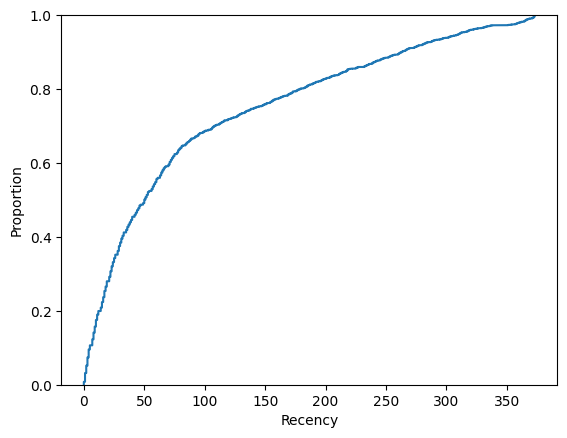

In [22]:
import seaborn as sns
sns.ecdfplot(data=RFM_score["Recency"])

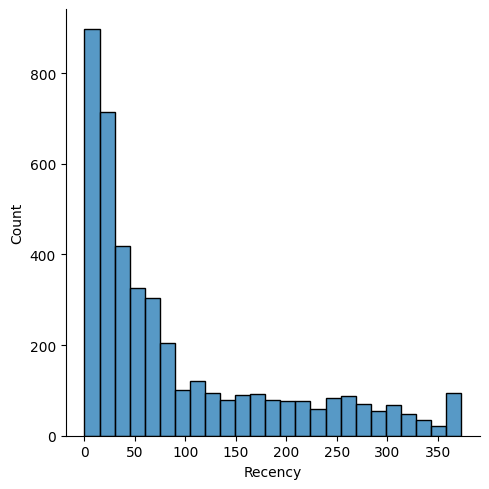

In [23]:
sns.displot(x=RFM_score["Recency"])

<Axes: xlabel='Frequency', ylabel='Proportion'>

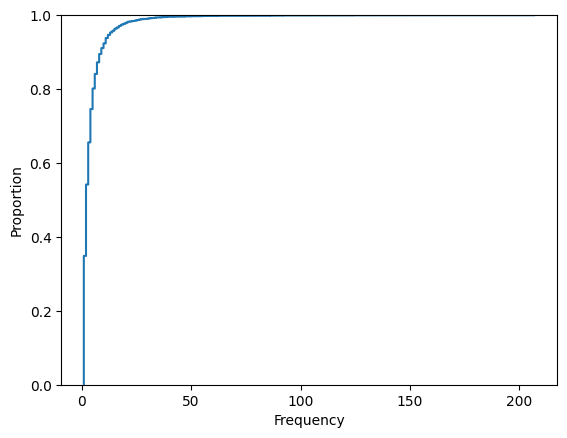

In [24]:
sns.ecdfplot(data=RFM_score["Frequency"])

<Axes: xlabel='Monetary', ylabel='Proportion'>

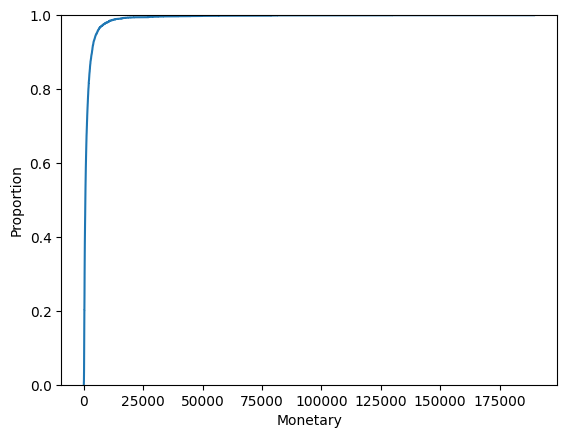

In [25]:
sns.ecdfplot(data=RFM_score["Monetary"])

## We will create a column (R_marks--> recency marks) to give the effective marks ,
- as high recency -- low marks
- low recency -- high marks

In [26]:
RFM_score["R_Marks"]=RFM_score["Recency"].rank(ascending=False)
RFM_score["F_Marks"]=RFM_score["Frequency"].rank(ascending=True)
RFM_score["M_Marks"]=RFM_score["Monetary"].rank(ascending=True)

In [27]:
RFM_score.head()

,CustomerID,Recency,Frequency,Monetary,R_Marks,F_Marks,M_Marks
0,12347.0,2,7,4060.40,4119.5,3682.0,3978.0
1,12348.0,75,4,1437.24,1628.0,3012.0,3130.0
2,12349.0,18,1,1417.60,3183.0,749.5,3108.0
3,12350.0,310,1,294.40,223.5,749.5,1072.0
4,12352.0,36,7,1385.74,2480.0,3682.0,3083.0


In [28]:
RFM_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4298 entries, 0 to 4297
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4298 non-null   float64
 1   Recency     4298 non-null   int64  
 2   Frequency   4298 non-null   int64  
 3   Monetary    4298 non-null   float64
 4   R_Marks     4298 non-null   float64
 5   F_Marks     4298 non-null   float64
 6   M_Marks     4298 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 235.2 KB


## We want to find the 'percentile' in the class/column.

In [29]:
RFM_score["R_Rank"]=(RFM_score["R_Marks"]/RFM_score["R_Marks"].max())*100

In [30]:
RFM_score.head()

,CustomerID,Recency,Frequency,Monetary,R_Marks,F_Marks,M_Marks,R_Rank
0,12347.0,2,7,4060.40,4119.5,3682.0,3978.0,96.216279
1,12348.0,75,4,1437.24,1628.0,3012.0,3130.0,38.024057
2,12349.0,18,1,1417.60,3183.0,749.5,3108.0,74.343104
3,12350.0,310,1,294.40,223.5,749.5,1072.0,5.220133
4,12352.0,36,7,1385.74,2480.0,3682.0,3083.0,57.923625


In [31]:
RFM_score["F_Rank"]=(RFM_score["F_Marks"]/RFM_score["F_Marks"].max())*100
RFM_score["M_Rank"]=(RFM_score["M_Marks"]/RFM_score["M_Marks"].max())*100

In [32]:
RFM_score.head()

,CustomerID,Recency,Frequency,Monetary,R_Marks,F_Marks,M_Marks,R_Rank,F_Rank,M_Rank
0,12347.0,2,7,4060.40,4119.5,3682.0,3978.0,96.216279,85.667752,92.554677
1,12348.0,75,4,1437.24,1628.0,3012.0,3130.0,38.024057,70.079107,72.824570
2,12349.0,18,1,1417.60,3183.0,749.5,3108.0,74.343104,17.438343,72.312704
3,12350.0,310,1,294.40,223.5,749.5,1072.0,5.220133,17.438343,24.941833
4,12352.0,36,7,1385.74,2480.0,3682.0,3083.0,57.923625,85.667752,71.731038


In [33]:
RFM=RFM_score.copy()

In [34]:
RFM["RFM_final"]=0.20*RFM["R_Rank"]+0.30*RFM["F_Rank"]+0.50*RFM["M_Rank"]

In [35]:
RFM.head()

,CustomerID,Recency,Frequency,Monetary,R_Marks,F_Marks,M_Marks,R_Rank,F_Rank,M_Rank,RFM_final
0,12347.0,2,7,4060.40,4119.5,3682.0,3978.0,96.216279,85.667752,92.554677,91.220920
1,12348.0,75,4,1437.24,1628.0,3012.0,3130.0,38.024057,70.079107,72.824570,65.040828
2,12349.0,18,1,1417.60,3183.0,749.5,3108.0,74.343104,17.438343,72.312704,56.256476
3,12350.0,310,1,294.40,223.5,749.5,1072.0,5.220133,17.438343,24.941833,18.746446
4,12352.0,36,7,1385.74,2480.0,3682.0,3083.0,57.923625,85.667752,71.731038,73.150570


In [36]:
RFM=RFM.round(2)
RFM

,CustomerID,Recency,Frequency,Monetary,R_Marks,F_Marks,M_Marks,R_Rank,F_Rank,M_Rank,RFM_final
0,12347.0,2,7,4060.40,4119.5,3682.0,3978.0,96.22,85.67,92.55,91.22
1,12348.0,75,4,1437.24,1628.0,3012.0,3130.0,38.02,70.08,72.82,65.04
2,12349.0,18,1,1417.60,3183.0,749.5,3108.0,74.34,17.44,72.31,56.26
3,12350.0,310,1,294.40,223.5,749.5,1072.0,5.22,17.44,24.94,18.75
4,12352.0,36,7,1385.74,2480.0,3682.0,3083.0,57.92,85.67,71.73,73.15
...,...,...,...,...,...,...,...,...,...,...,...
4293,18280.0,277,1,180.60,354.0,749.5,606.0,8.27,17.44,14.10,13.93
4294,18281.0,180,1,80.82,854.0,749.5,124.0,19.95,17.44,2.89,10.66
4295,18282.0,7,2,178.05,3805.5,1913.5,588.0,88.88,44.52,13.68,37.97
4296,18283.0,3,16,2088.93,4029.0,4147.5,3508.0,94.10,96.50,81.62,88.58


# Mannual Clustering Approach

#### lets create 4 group -- 4 no of cluster (**Silver**, **Gold**, **Platinum**, **Diamond**)

In [37]:
# defining a function to create cluster
def cust_category(x):
    if x<=27.72:
        return "Silver"
    if x<=48.78:
        return "Gold"
    if x<=71.49:
        return "Platinum"
    else:
        return "Diamond"

In [38]:
RFM["Group"]=RFM["RFM_final"].apply(cust_category)
RFM.head(10)

,CustomerID,Recency,Frequency,Monetary,R_Marks,F_Marks,M_Marks,R_Rank,F_Rank,M_Rank,RFM_final,Group
0,12347.0,2,7,4060.40,4119.5,3682.0,3978.0,96.22,85.67,92.55,91.22,Diamond
1,12348.0,75,4,1437.24,1628.0,3012.0,3130.0,38.02,70.08,72.82,65.04,Platinum
2,12349.0,18,1,1417.60,3183.0,749.5,3108.0,74.34,17.44,72.31,56.26,Platinum
3,12350.0,310,1,294.40,223.5,749.5,1072.0,5.22,17.44,24.94,18.75,Silver
4,12352.0,36,7,1385.74,2480.0,3682.0,3083.0,57.92,85.67,71.73,73.15,Diamond
5,12353.0,204,1,89.00,721.0,749.5,138.0,16.84,17.44,3.21,10.20,Silver
6,12354.0,232,1,1079.40,599.5,749.5,2819.0,14.00,17.44,65.59,40.83,Gold
7,12355.0,214,1,459.40,667.5,749.5,1717.0,15.59,17.44,39.95,28.32,Gold
8,12356.0,22,3,2487.43,3011.5,2573.5,3656.0,70.34,59.88,85.06,74.56,Diamond
9,12357.0,33,1,6182.67,2547.0,749.5,4130.0,59.49,17.44,96.09,65.17,Platinum


In [39]:
RFM["Group"].value_counts()

Group
Gold        1086
Diamond     1082
Silver      1075
Platinum    1055
Name: count, dtype: int64

<Axes: xlabel='Frequency', ylabel='RFM_final'>

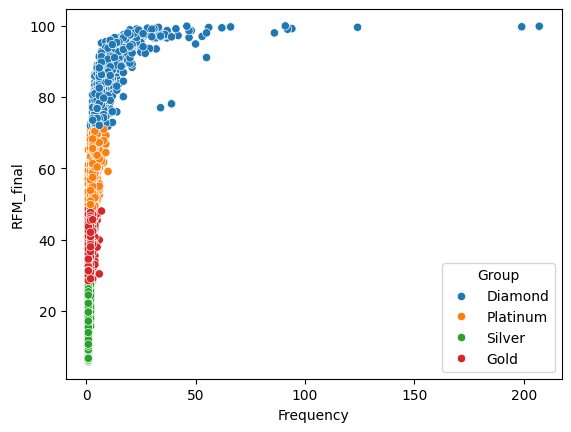

In [40]:
sns.scatterplot(data=RFM,x="Frequency",y="RFM_final",hue="Group")

<Axes: xlabel='F_Marks', ylabel='RFM_final'>

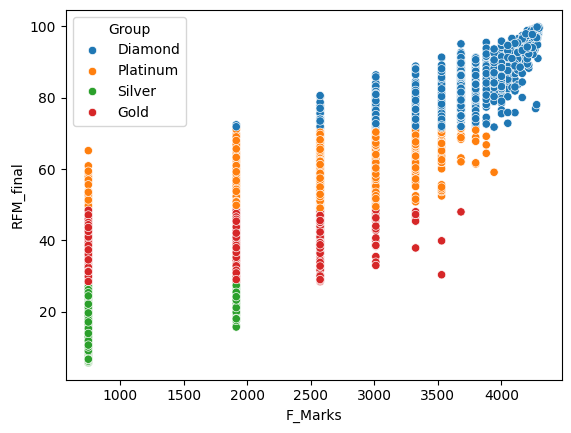

In [41]:
sns.scatterplot(data=RFM,x="F_Marks",y="RFM_final",hue="Group")

<Axes: xlabel='M_Marks', ylabel='RFM_final'>

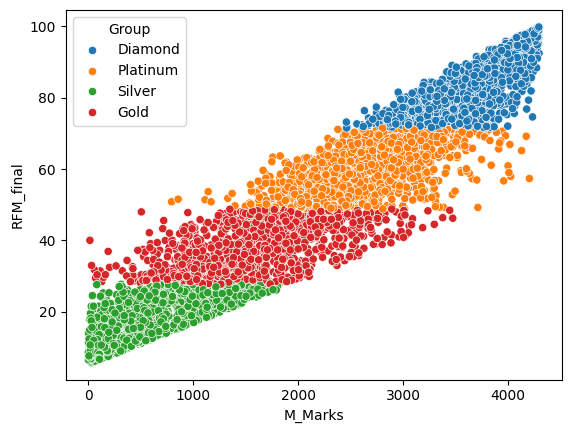

In [42]:
sns.scatterplot(data=RFM,x="M_Marks",y="RFM_final",hue="Group")

<Axes: xlabel='R_Marks', ylabel='RFM_final'>

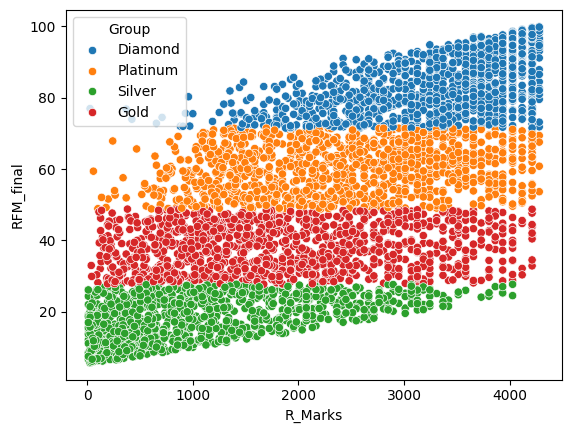

In [43]:
sns.scatterplot(data=RFM,x="R_Marks",y="RFM_final",hue="Group")

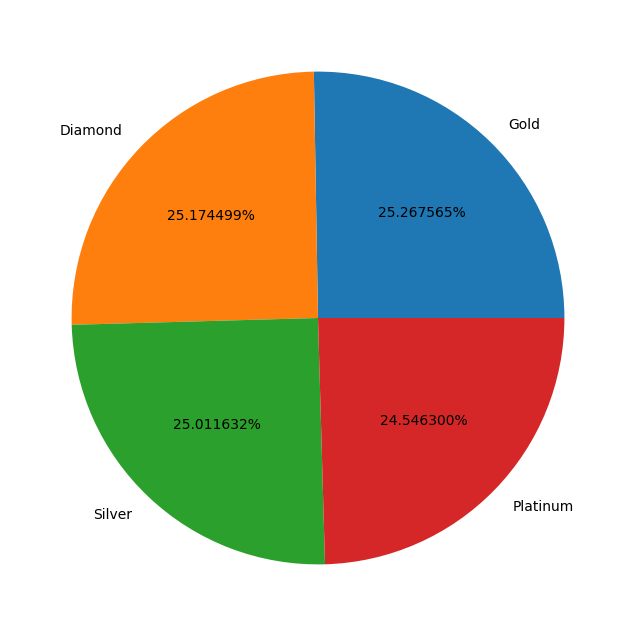

In [44]:
plt.figure(figsize=(12,8))
plt.pie(RFM.Group.value_counts(),labels=RFM.Group.value_counts().index,autopct="%2f%%")
plt.show()

# Customer Segmentation Using K-Mean Cluster

In [45]:
# Create a separate dataset
final_data=pd.DataFrame(RFM["RFM_final"])
final_data.head()

,RFM_final
0,91.22
1,65.04
2,56.26
3,18.75
4,73.15


In [46]:
scaler=MinMaxScaler()
final_data_scaled=scaler.fit_transform(final_data)

In [47]:
final_data_scaled=pd.DataFrame(final_data_scaled,columns=final_data.columns)
final_data_scaled.head()

,RFM_final
0,0.907865
1,0.629976
2,0.536780
3,0.138626
4,0.716060


Text(0, 0.5, 'Sum of square error')

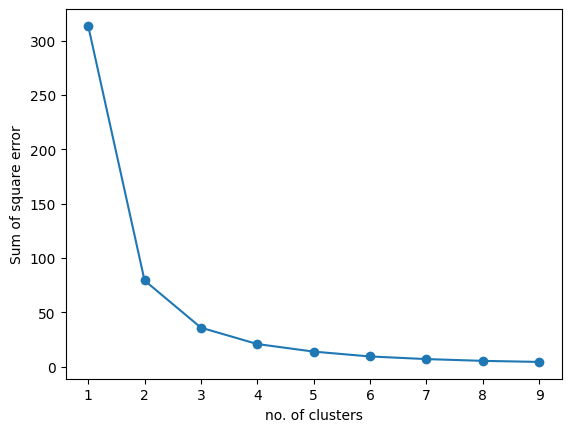

In [48]:
SSE=[]
for i in range(1,10):
    kmeans1=KMeans(max_iter=100,random_state=100,n_clusters=i)
    kmeans1.fit_predict(final_data_scaled)
    SSE.append(kmeans1.inertia_)
    
plt.plot(range(1,10),SSE,marker="o")
plt.xlabel("no. of clusters")
plt.ylabel("Sum of square error")

In [49]:
for i in range(2,9):
    kmeans2=KMeans(max_iter=100,random_state=100,n_clusters=i)
    kmeans2.fit(final_data_scaled)
    silhoutte=silhouette_score(final_data_scaled,kmeans2.labels_)
    print("for {} score {}".format(i,silhoutte))

for 2 score 0.6266692830064818
for 3 score 0.588501685090152
for 4 score 0.5657484486414671
for 5 score 0.5430031944012894
for 6 score 0.547158111858847
for 7 score 0.5430980806152614
for 8 score 0.5407660125398367


In [50]:
kmeans=KMeans(n_clusters=4,random_state=101)
y_kmeans=kmeans.fit_predict(final_data_scaled)
y_kmeans

array([1, 2, 2, ..., 3, 1, 2])

### Copy and Create New_DataFrame

In [51]:
RFM_new = RFM.copy()

In [52]:
RFM_new.drop(columns='Group', axis=1, inplace=True)

In [53]:
RFM_new["Cluster"]=y_kmeans

In [54]:
RFM_new.head(10)

,CustomerID,Recency,Frequency,Monetary,R_Marks,F_Marks,M_Marks,R_Rank,F_Rank,M_Rank,RFM_final,Cluster
0,12347.0,2,7,4060.40,4119.5,3682.0,3978.0,96.22,85.67,92.55,91.22,1
1,12348.0,75,4,1437.24,1628.0,3012.0,3130.0,38.02,70.08,72.82,65.04,2
2,12349.0,18,1,1417.60,3183.0,749.5,3108.0,74.34,17.44,72.31,56.26,2
3,12350.0,310,1,294.40,223.5,749.5,1072.0,5.22,17.44,24.94,18.75,0
4,12352.0,36,7,1385.74,2480.0,3682.0,3083.0,57.92,85.67,71.73,73.15,2
5,12353.0,204,1,89.00,721.0,749.5,138.0,16.84,17.44,3.21,10.20,0
6,12354.0,232,1,1079.40,599.5,749.5,2819.0,14.00,17.44,65.59,40.83,3
7,12355.0,214,1,459.40,667.5,749.5,1717.0,15.59,17.44,39.95,28.32,0
8,12356.0,22,3,2487.43,3011.5,2573.5,3656.0,70.34,59.88,85.06,74.56,1
9,12357.0,33,1,6182.67,2547.0,749.5,4130.0,59.49,17.44,96.09,65.17,2


In [55]:
RFM_new["Cluster"].value_counts()

Cluster
0    1178
3    1106
2    1060
1     954
Name: count, dtype: int64

In [56]:
RFM["Group"].value_counts()

Group
Gold        1086
Diamond     1082
Silver      1075
Platinum    1055
Name: count, dtype: int64

In [57]:
# print(f"Silver min:{RFM.loc[RFM["Cluster_group"]=='Silver'].RFM_final.min()} silver max:{RFM.loc[RFM["Cluster_group"]=='Silver'].RFM_final.max()}")

In [58]:
print("Cluster_0: Min_Max_Values")
print(RFM_new.loc[RFM_new["Cluster"]==0].RFM_final.min())
print(RFM_new.loc[RFM_new["Cluster"]==0].RFM_final.max())
print()
print("Cluster_1: Min_Max_Values")
print(RFM_new.loc[RFM_new["Cluster"]==1].RFM_final.min())
print(RFM_new.loc[RFM_new["Cluster"]==1].RFM_final.max())
print()
print("Cluster_2: Min_Max_Values")
print(RFM_new.loc[RFM_new["Cluster"]==2].RFM_final.min())
print(RFM_new.loc[RFM_new["Cluster"]==2].RFM_final.max())
print()
print("Cluster_3: Min_Max_Values")
print(RFM_new.loc[RFM_new["Cluster"]==3].RFM_final.min())
print(RFM_new.loc[RFM_new["Cluster"]==3].RFM_final.max())

Cluster_0: Min_Max_Values
5.69
29.61

Cluster_1: Min_Max_Values
73.98
99.9

Cluster_2: Min_Max_Values
51.43
73.96

Cluster_3: Min_Max_Values
29.65
51.4


In [59]:
# Labeling the cluster accourding to their range
label_map = {0: 'Silver', 1: 'Diamond', 2: 'Platinum', 3: 'Gold'}
RFM_new["Cluster_group"] = RFM_new["Cluster"].map(label_map)

In [60]:
RFM_new.head(10)

,CustomerID,Recency,Frequency,Monetary,R_Marks,F_Marks,M_Marks,R_Rank,F_Rank,M_Rank,RFM_final,Cluster,Cluster_group
0,12347.0,2,7,4060.40,4119.5,3682.0,3978.0,96.22,85.67,92.55,91.22,1,Diamond
1,12348.0,75,4,1437.24,1628.0,3012.0,3130.0,38.02,70.08,72.82,65.04,2,Platinum
2,12349.0,18,1,1417.60,3183.0,749.5,3108.0,74.34,17.44,72.31,56.26,2,Platinum
3,12350.0,310,1,294.40,223.5,749.5,1072.0,5.22,17.44,24.94,18.75,0,Silver
4,12352.0,36,7,1385.74,2480.0,3682.0,3083.0,57.92,85.67,71.73,73.15,2,Platinum
5,12353.0,204,1,89.00,721.0,749.5,138.0,16.84,17.44,3.21,10.20,0,Silver
6,12354.0,232,1,1079.40,599.5,749.5,2819.0,14.00,17.44,65.59,40.83,3,Gold
7,12355.0,214,1,459.40,667.5,749.5,1717.0,15.59,17.44,39.95,28.32,0,Silver
8,12356.0,22,3,2487.43,3011.5,2573.5,3656.0,70.34,59.88,85.06,74.56,1,Diamond
9,12357.0,33,1,6182.67,2547.0,749.5,4130.0,59.49,17.44,96.09,65.17,2,Platinum


In [61]:
RFM_new["Cluster_group"].value_counts()

Cluster_group
Silver      1178
Gold        1106
Platinum    1060
Diamond      954
Name: count, dtype: int64

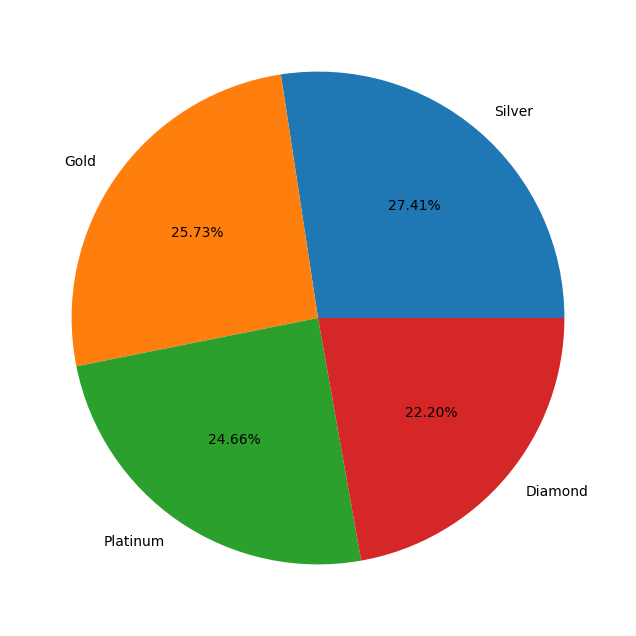

In [62]:
plt.figure(figsize=(12,8))
plt.pie(RFM_new.Cluster_group.value_counts(),labels=RFM_new.Cluster_group.value_counts().index,autopct="%1.2f%%")
plt.show()

In [63]:
labels=kmeans.labels_
from sklearn.metrics import silhouette_score
print(silhouette_score(final_data_scaled,labels))

0.5626055615688348


### **Model_Evaluation**
- We find very good silhouette_score, so model effectove

# **Analysing the Sales trend:**

**Goal:-Analysing the business sales trend**

1. When is the highest sales(Month/season/day/timing )
2. when is the rush hour- month /season day/ morning afternoon/evening /weekdays/weekends

In [64]:
df_final.head()

,Invoice_No,Invoice_Date,CustomerID,TotalPrice
0,536365,2022-12-01 08:26:00,17850.0,139.12
1,536366,2022-12-01 08:28:00,17850.0,22.20
2,536367,2022-12-01 08:34:00,13047.0,278.73
3,536368,2022-12-01 08:34:00,13047.0,70.05
4,536369,2022-12-01 08:35:00,13047.0,17.85


## **Feature Engineering**
- from month - we can create **seasons**
- from day - we can create **week-day**/ **weekends**
- from hour - we can create **morning**, **afternoon**, **evening** , **night**

In [65]:
import datetime as dt
df_final["Day"]=df_final["Invoice_Date"].dt.day_name()
df_final["Month"]=df_final["Invoice_Date"].dt.month
df_final["Hour"]=df_final["Invoice_Date"].dt.hour
df_final["Weekday"]=df_final["Invoice_Date"].dt.weekday
df_final['Month_name'] = df_final['Invoice_Date'].dt.month_name()
df_final["Weekend"]=np.where((df_final["Day"]=="Saturday")|(df_final["Day"]=="Sunday"),"Weekend","Weekdays")

In [66]:
df_final.head()

,Invoice_No,Invoice_Date,CustomerID,TotalPrice,Day,Month,Hour,Weekday,Month_name,Weekend
0,536365,2022-12-01 08:26:00,17850.0,139.12,Thursday,12,8,3,December,Weekdays
1,536366,2022-12-01 08:28:00,17850.0,22.20,Thursday,12,8,3,December,Weekdays
2,536367,2022-12-01 08:34:00,13047.0,278.73,Thursday,12,8,3,December,Weekdays
3,536368,2022-12-01 08:34:00,13047.0,70.05,Thursday,12,8,3,December,Weekdays
4,536369,2022-12-01 08:35:00,13047.0,17.85,Thursday,12,8,3,December,Weekdays


In [67]:
# season - we will use the month information
def cal_season(x):
    if x in [11,12,1,2]:
        return "Winter"
    elif x in [3,4]:
        return "Spring"
    elif x in [5,6,7]:
        return "Summer"
    else:
        return "Monsoon"

In [68]:
# timing - we will use the hour information
def cal_timing(x):
    if x in range(22,4):
        return " night"
    elif x in range(4,11):
        return "Morning"
    elif x in range(11,16):
        return "Afternoon"
    else:
        return "Evening"

In [69]:
df_final["Season"]=df_final["Month"].apply(cal_season)
df_final["Timing"]=df_final["Hour"].apply(cal_timing)
df_final.head(10)

,Invoice_No,Invoice_Date,CustomerID,TotalPrice,Day,Month,Hour,Weekday,Month_name,Weekend,Season,Timing
0,536365,2022-12-01 08:26:00,17850.0,139.12,Thursday,12,8,3,December,Weekdays,Winter,Morning
1,536366,2022-12-01 08:28:00,17850.0,22.20,Thursday,12,8,3,December,Weekdays,Winter,Morning
2,536367,2022-12-01 08:34:00,13047.0,278.73,Thursday,12,8,3,December,Weekdays,Winter,Morning
3,536368,2022-12-01 08:34:00,13047.0,70.05,Thursday,12,8,3,December,Weekdays,Winter,Morning
4,536369,2022-12-01 08:35:00,13047.0,17.85,Thursday,12,8,3,December,Weekdays,Winter,Morning
5,536370,2022-12-01 08:45:00,12583.0,801.86,Thursday,12,8,3,December,Weekdays,Winter,Morning
6,536371,2022-12-01 09:00:00,13748.0,204.00,Thursday,12,9,3,December,Weekdays,Winter,Morning
7,536372,2022-12-01 09:01:00,17850.0,22.20,Thursday,12,9,3,December,Weekdays,Winter,Morning
8,536373,2022-12-01 09:02:00,17850.0,259.86,Thursday,12,9,3,December,Weekdays,Winter,Morning
9,536374,2022-12-01 09:09:00,15100.0,350.40,Thursday,12,9,3,December,Weekdays,Winter,Morning


In [70]:
# couting the sales by each day
df_final["Day"].value_counts()

Day
Friday       3940
Thursday     3360
Wednesday    3088
Tuesday      2780
Saturday     2746
Monday       2162
Name: count, dtype: int64

Text(0, 0.5, 'No. of invoice')

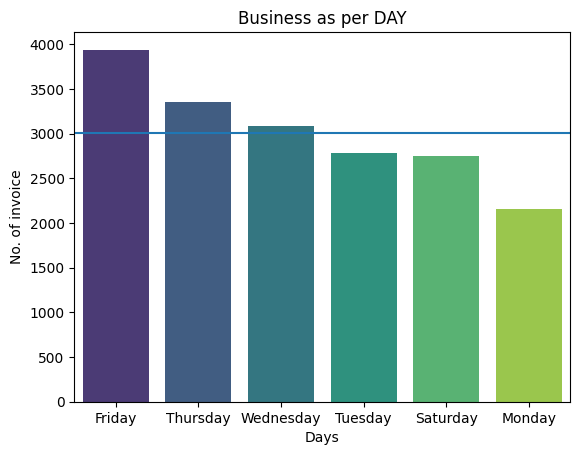

In [71]:
# visualizing the sale by day
sns.barplot(x=df_final["Day"].value_counts().index,
            y=df_final["Day"].value_counts().values,
           palette='viridis')
plt.axhline(y=df_final["Day"].value_counts().values.mean())
plt.title("Business as per DAY")
plt.xlabel("Days")
plt.ylabel("No. of invoice")

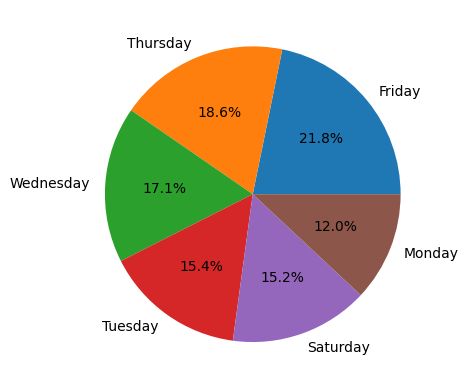

In [72]:
plt.pie(df_final["Day"].value_counts().values,
        labels=df_final["Day"].value_counts().index,
        autopct='%.1f%%')
plt.show()

In [73]:
# couting the sales by each months
df_final["Month_name"].value_counts()

Month_name
November     2597
December     2128
October      1873
September    1711
May          1514
June         1362
July         1299
March        1290
August       1239
April        1118
February      976
January       969
Name: count, dtype: int64

Text(0, 0.5, 'No. of invoice')

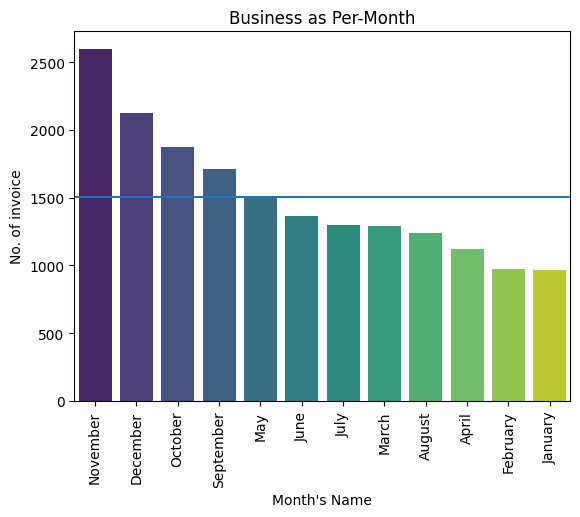

In [74]:
# visualizing the sale by month
sns.barplot(x=df_final["Month_name"].value_counts().index,
            y=df_final["Month_name"].value_counts().values,
           palette='viridis')
plt.axhline(y=df_final["Month_name"].value_counts().values.mean())
plt.title("Business as Per-Month")
plt.xticks(rotation=90)
plt.xlabel("Month's Name")
plt.ylabel("No. of invoice")

In [75]:
# couting the sales by season
df_final["Season"].value_counts()

Season
Winter     6670
Monsoon    4823
Summer     4175
Spring     2408
Name: count, dtype: int64

Text(0, 0.5, 'No. of invoice')

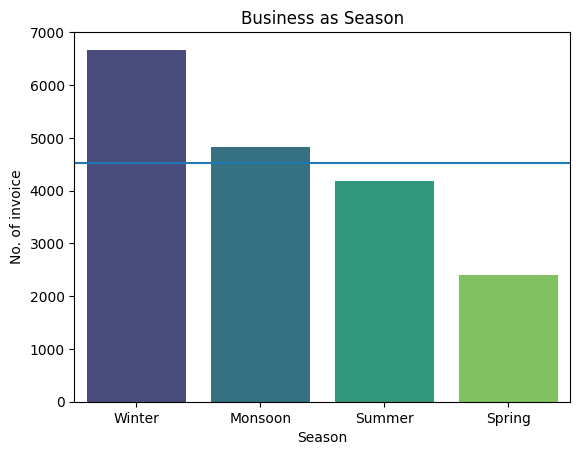

In [76]:
# visualizing the sale by day
sns.barplot(x=df_final["Season"].value_counts().index,
            y=df_final["Season"].value_counts().values,
           palette='viridis')
plt.axhline(y=df_final["Season"].value_counts().values.mean())
plt.title("Business as Season")
plt.xlabel("Season")
plt.ylabel("No. of invoice")

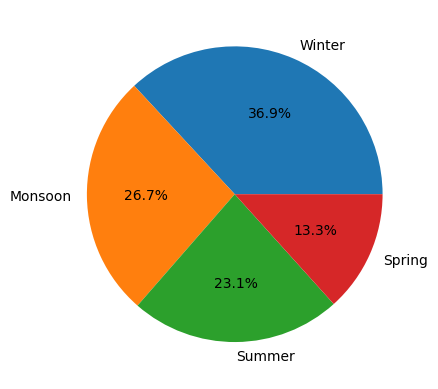

In [79]:
plt.pie(df_final["Season"].value_counts().values,
        labels=df_final["Season"].value_counts().index,
        autopct='%.1f%%')
plt.show()

In [80]:
# couting the sales by season
df_final["Timing"].value_counts()

Timing
Afternoon    12070
Morning       4080
Evening       1926
Name: count, dtype: int64

Text(0, 0.5, 'No. of invoice')

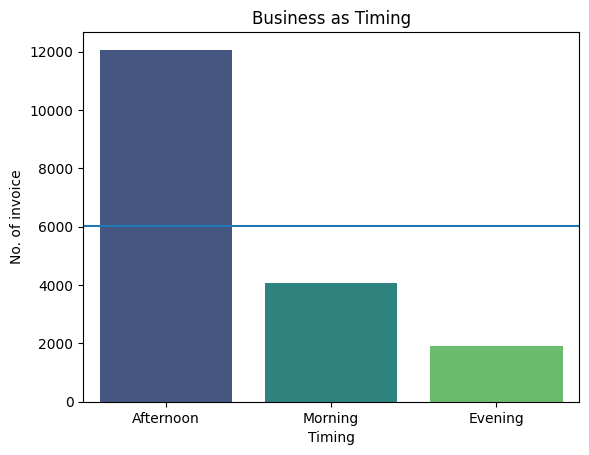

In [81]:
# visualizing the sale Timing
sns.barplot(x=df_final["Timing"].value_counts().index,
            y=df_final["Timing"].value_counts().values,
           palette='viridis')
plt.axhline(y=df_final["Timing"].value_counts().values.mean())
plt.title("Business as Timing")
plt.xlabel("Timing")
plt.ylabel("No. of invoice")

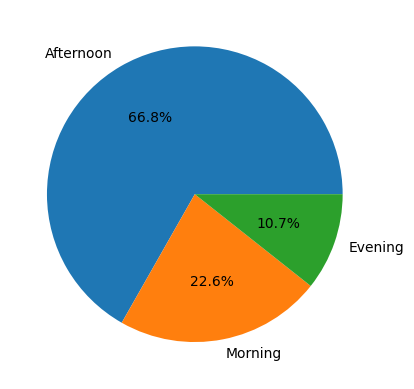

In [82]:
plt.pie(df_final["Timing"].value_counts().values,
        labels=df_final["Timing"].value_counts().index,
        autopct='%.1f%%')
plt.show()

In [83]:
# couting the sales by Weekend
df_final["Weekend"].value_counts()

Weekend
Weekdays    15330
Weekend      2746
Name: count, dtype: int64

Text(0, 0.5, 'No. of invoice')

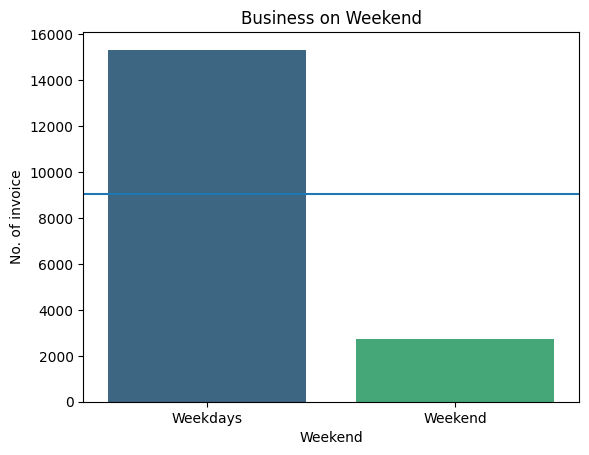

In [84]:
# visualizing the sale Weekend
sns.barplot(x=df_final["Weekend"].value_counts().index,
            y=df_final["Weekend"].value_counts().values,
           palette='viridis')
plt.axhline(y=df_final["Weekend"].value_counts().values.mean())
plt.title("Business on Weekend")
plt.xlabel("Weekend")
plt.ylabel("No. of invoice")

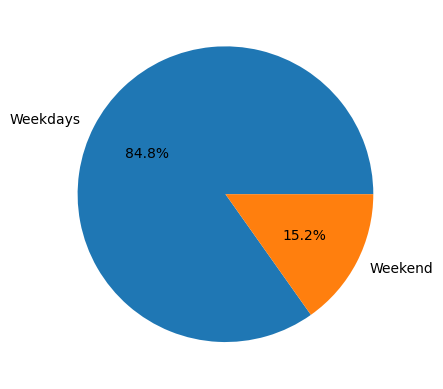

In [85]:
plt.pie(df_final["Weekend"].value_counts().values,
        labels=df_final["Weekend"].value_counts().index,
        autopct='%.1f%%')
plt.show()

# **Sales Trend**

- Sales is in increasing trend
- Winter season mainly November and December Sales is high...It can be due to Festival Season mostly or Sales is increasing month on month also.
- Thursday Sales is high than other day ...Sunday is low sale and saturday no sale so Saturday is mall close may be and sunday its open for shorter period of time beacuse Sunday Evening there is no sale as well

# **Customer Life Time Value(CLTV)**

**Overview:**

Customer life time value(CLTV) Customer Lifetime Value is the amount of monetary value a customer will bring to your company during their lifetime, from the first to the last purchase. In other words, it is a number that represents the total amount spent by a single customer on your products or services over their lifespan. Based on that specific number, you will have a better sense of how much you can spend on customer acquisition, how much you should invest into your existing customers, and you can define strategies and a budget to increase your Customer Lifetime Value in eCommerce or retain your high-value customers.

In [86]:
df2=df1.copy()
df2["avg_order_value"]=RFM_score["Monetary"]/RFM_score["Frequency"]
df2["profit_margin"]=RFM_score["Monetary"]*0.25

In [87]:
purchase_frequency=sum(RFM_score["Frequency"])/RFM_score.shape[0]
repeat_rate=RFM_score[RFM_score["Frequency"]>1].shape[0]/RFM_score.shape[0]
churn_rate=1-repeat_rate
df2["CLTV"]=df2["avg_order_value"]*purchase_frequency/churn_rate

In [88]:
df2.head()

,Invoice_No,Item_Code,Item_Description,Quantity,UnitPrice,CustomerID,Invoice_Date,TotalPrice,avg_order_value,profit_margin,CLTV
0,536365,85123A,white hanging heart t-light holder,6,2.55,17850.0,2022-12-01 08:26:00,15.30,580.057143,1015.100,6999.407820
1,536365,71053,white metal lantern,6,3.39,17850.0,2022-12-01 08:26:00,20.34,359.310000,359.310,4335.705981
2,536365,84406B,cream cupid hearts coat hanger,8,2.75,17850.0,2022-12-01 08:26:00,22.00,1417.600000,354.400,17105.832844
3,536365,84029G,knitted union flag hot water bottle,6,3.39,17850.0,2022-12-01 08:26:00,20.34,294.400000,73.600,3552.452870
4,536365,84029E,red woolly hottie white heart.,6,3.39,17850.0,2022-12-01 08:26:00,20.34,197.962857,346.435,2388.769430


In [89]:
df2["cust_lifetime_value"]=df2["CLTV"]*df2["profit_margin"]

In [90]:
df2.head()

,Invoice_No,Item_Code,Item_Description,Quantity,UnitPrice,CustomerID,Invoice_Date,TotalPrice,avg_order_value,profit_margin,CLTV,cust_lifetime_value
0,536365,85123A,white hanging heart t-light holder,6,2.55,17850.0,2022-12-01 08:26:00,15.30,580.057143,1015.100,6999.407820,7.105099e+06
1,536365,71053,white metal lantern,6,3.39,17850.0,2022-12-01 08:26:00,20.34,359.310000,359.310,4335.705981,1.557863e+06
2,536365,84406B,cream cupid hearts coat hanger,8,2.75,17850.0,2022-12-01 08:26:00,22.00,1417.600000,354.400,17105.832844,6.062307e+06
3,536365,84029G,knitted union flag hot water bottle,6,3.39,17850.0,2022-12-01 08:26:00,20.34,294.400000,73.600,3552.452870,2.614605e+05
4,536365,84029E,red woolly hottie white heart.,6,3.39,17850.0,2022-12-01 08:26:00,20.34,197.962857,346.435,2388.769430,8.275533e+05


In [91]:
# Creation of month year
df2["Invoice_Date"]=pd.to_datetime(df2["Invoice_Date"])
df2["month_yr"]=df2["Invoice_Date"].apply(lambda x: x.strftime("%b-%Y")) # extract the month and year
df2.head()
"""
creating a pivot table taking the columns as input and groups the entries 
into two dimentsional table in sucf a way that provides a multidimentsional 
summation of the data.
"""
sale=df2.pivot_table(index=["CustomerID"],columns=["month_yr"],values="TotalPrice",aggfunc="sum",fill_value=0).reset_index()

In [92]:
sale.head()

month_yr,CustomerID,Apr-2023,Aug-2023,Dec-2022,Dec-2023,Feb-2023,Jan-2023,Jul-2023,Jun-2023,Mar-2023,May-2023,Nov-2023,Oct-2023,Sep-2023
0,12347.0,386.65,584.91,711.79,224.82,0.0,475.39,0.0,382.52,0.00,0.0,0.00,1294.32,0.0
1,12348.0,327.00,0.00,652.80,0.00,0.0,187.44,0.0,0.00,0.00,0.0,0.00,0.00,270.0
2,12349.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,1417.60,0.00,0.0
3,12350.0,0.00,0.00,0.00,0.00,294.4,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0
4,12352.0,0.00,0.00,0.00,0.00,296.5,0.00,0.0,0.00,345.01,0.0,231.73,0.00,512.5


In [93]:
sale["CLV"]=sale.iloc[:,2:].sum(axis=1)# sum all the months sale
sale.head()

month_yr,CustomerID,Apr-2023,Aug-2023,Dec-2022,Dec-2023,Feb-2023,Jan-2023,Jul-2023,Jun-2023,Mar-2023,May-2023,Nov-2023,Oct-2023,Sep-2023,CLV
0,12347.0,386.65,584.91,711.79,224.82,0.0,475.39,0.0,382.52,0.00,0.0,0.00,1294.32,0.0,3673.75
1,12348.0,327.00,0.00,652.80,0.00,0.0,187.44,0.0,0.00,0.00,0.0,0.00,0.00,270.0,1110.24
2,12349.0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,1417.60,0.00,0.0,1417.60
3,12350.0,0.00,0.00,0.00,0.00,294.4,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,294.40
4,12352.0,0.00,0.00,0.00,0.00,296.5,0.00,0.0,0.00,345.01,0.0,231.73,0.00,512.5,1385.74


In [94]:
sale.columns

Index(['CustomerID', 'Apr-2023', 'Aug-2023', 'Dec-2022', 'Dec-2023',
       'Feb-2023', 'Jan-2023', 'Jul-2023', 'Jun-2023', 'Mar-2023', 'May-2023',
       'Nov-2023', 'Oct-2023', 'Sep-2023', 'CLV'],
      dtype='object', name='month_yr')

In [95]:
X = sale[['Apr-2023', 'Aug-2023', 'Dec-2022', 'Dec-2023',
       'Feb-2023', 'Jan-2023', 'Jul-2023', 'Jun-2023', 'Mar-2023', 'May-2023',
       'Nov-2023', 'Oct-2023', 'Sep-2023']]
Y = sale["CLV"]

# **Regression Model**

In [96]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2, random_state = 42)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,Y_train)

Y_pred=lr.predict(X_test)


print(lr.intercept_)
print(lr.coef_)

2.2737367544323206e-12
[-8.10861748e-15  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00]


In [97]:
from sklearn import metrics

print("R-Square", metrics.r2_score(Y_test,Y_pred))
print("MAE",metrics.mean_absolute_error(Y_test,Y_pred))
print("MSE",metrics.mean_squared_error(Y_test,Y_pred))
print("RMSE",np.sqrt(metrics.mean_squared_error(Y_test,Y_pred)))

R-Square 1.0
MAE 3.82202957721674e-12
MSE 7.269996271890509e-23
RMSE 8.52642731270871e-12


# **Summary:**

This model (ML algorithm) helps to understand the patterns,it will also categorize the customers according to their CLTV predictions.The Marketing strategy is important here considering that CLTV can figure out most profitable cutomers, but how we are going to make profit from them, will depend on the adopted marketing strategy. Moreover the loyalty programs can be formulated based on the insights.

# **Limitation:**

It is not clear how a regression model can be used to forecast the dynamics of buyer behavior well into the future and then tie it all back into the present value for each customer.